In [47]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.3.0


In [48]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 2


Functions to be put in helpfile

In [12]:
def get_y_true(samples, class_indices, classes):
    y_true = np.zeros((samples, len(class_indices))) # nr_rows=nr_images; nr_columns=nr_classes
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

# def get_y_true(classes, preset_nr_classes=0):
#     """Gets one-hot encoded matrix of format (nr_images)x(nr_classes)."""
#     nr_images = len(classes)
#     if not preset_nr_classes:
#         nr_classes = len(set([item for sublist in classes for item in sublist]))
#     else:
#         nr_classes = preset_nr_classes
#     y_true = np.zeros((nr_images, nr_classes))
#     for row_idx, row in enumerate(classes):
#         for idx in row:
#             y_true[row_idx, idx] = 1
#     return y_true

def balance_test(classes, class_names, test_df):
        """ 
        Constructs a sort of more balanced test set in a dummy way by adding to it only the images that contain 
        the - for the moment - most uncommon class.
        Inputs:
            - classes: [[]]
            - class_names: list with all labels: 
            - test_df: dataframe with rows containing image files and labels
        """
        y_true = get_y_true(classes)
        sorted_indices = np.argsort(np.sum(y_true, axis=0))
        sorted_class_names = np.array(list(class_names))[sorted_indices]
        least_common_class = sorted_class_names[0]
        balanced_classes = []
        row_ids = []
        counter = 0 
        for index, row in test_df.iterrows():
            counter += 1
            if counter % 10 == 0:
                y_true = get_y_true(balanced_classes, 40)
                sorted_indices = np.argsort(np.sum(y_true, axis=0))
                sorted_class_names = np.array(class_names)[sorted_indices]
                least_common_class = sorted_class_names[0]
            if least_common_class in row.labels:
                balanced_classes.append(row.labels)
                row_ids.append(index)

        return test_df.loc[row_ids, :]
    
def plot_distribution(classes, class_names=[], description='None', plot_log=False, lims=()):
    y_true = get_y_true(classes)
    sorted_indices = np.argsort(np.sum(y_true, axis=0))
    sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]
    plt.figure(figsize=(12, 15))
    plt.title('Number of images per class' + description)
    if plot_log:
        plt.xscale('log')
    if lims:
        plt.xlim(lims)
    plt.xlabel('Count')
    plt.grid(True)
    plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='blue', alpha=0.65)
    if class_names:
        plt.yticks(range(y_true.shape[1]), np.array(list(class_names))[sorted_indices])


### Hyperparameters

In [49]:
from PIL import PngImagePlugin  

EPOCHS = 15
IMAGE_DIMENSION = 64
MINIMAL_NR_IMAGES = 1_000
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

## 1. Load train and test dataframes

In [ ]:
train_df = pd.from_json('data/splitted_dfs_20220531/train_df.json.bz2', compression='bz2')
test_df = pd.from_json('data/splitted_dfs_20220531/test_df.json.bz2', compression='bz2')

### Create generators with augmentations

In [50]:
# Data generator for training and validation sets, performs data augmentations
train_generator = ImageDataGenerator(validation_split=0.05, 
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest') 

print('\n----------- Train images -----------')
train = train_generator.flow_from_dataframe(dataframe=train_df, 
                                            directory='/scratch/WIT_Dataset/images', 
                                            x_col='url', 
                                            y_col='labels', 
                                            class_mode='categorical',
                                            subset='training',
                                            batch_size=32,
                                            validate_filenames=True,
                                            target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

print('\n----------- Validation images -----------')          
val = train_generator.flow_from_dataframe(dataframe=train_df, 
                                          directory='/scratch/WIT_Dataset/images', 
                                          x_col='url', 
                                          y_col='labels', 
                                          class_mode='categorical',
                                          subset='validation',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

# Data generator for test set
test_generator = ImageDataGenerator() 
print('\n----------- Test images -----------')          
test = test_generator.flow_from_dataframe(dataframe=test_df,
                                          directory='/scratch/WIT_Dataset/images',
                                          x_col='url', 
                                          y_col='labels', 
                                          batch_size=32,
                                          class_mode='categorical',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

N_LABELS = len(train.class_indices)

## 2. Construct and train model
Here, we construct a model where the first layers are EfficientNetB0 pre-trained on ImageNet-1k(https://keras.io/api/applications/efficientnet/) with added layers to the end, and train these final end layers with our training data.

In [51]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def create_model():
    """Take efficientnet pre-trained on imagenet-1k, not including the last layer."""
    efficient_net = EfficientNetB0(include_top=False, 
                                   weights='imagenet', 
                                   classes=N_LABELS,
                                   input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3))
    efficient_net.trainable=False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(N_LABELS, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

model = create_model()

In [86]:
# y_true = get_y_true(train.samples, train.class_indices, train.classes)

# def compute_class_weights(y_true):
#     """
#     Computes class_weights to compensate imbalanced classes. Inspired in 
#     'https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99'.
#     Dictionary mapping class indices (integers) to a weight (float) value, 
#     used for weighting the loss function (during training only).
#     """
#     class_count = y_true.sum(axis=0)
#     n_samples = y_true.shape[0] 
#     n_classes = y_true.shape[1]

#     # Compute class weights using balanced method
#     class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
#     class_labels = range(len(class_weights))
#     return dict(zip(class_labels, class_weights))

# class_weights = compute_class_weights(y_true)#dict(enumerate(y_true.sum().sum() / y_true.sum(axis=0)))
# print(class_weights)

In [ ]:
# Save the weights using the `checkpoint_path` format
# https://www.youtube.com/watch?v=HxtBIwfy0kM
# https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage
checkpoint_path = "checkpoints/naive_26_labels_weights_20220531/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 save_weights_only=False, 
                                                 save_freq='epoch' # save after each epoch
                                                 verbose=1)
# https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
history_callback = tf.keras.callbacks.CSVLogger('checkpoints/naive_26_labels_weights_20220531/history.csv', 
                                                separator=',', 
                                                append=True)

model.save(checkpoint_path.format(epoch=0))

history = model.fit(train, 
                    epochs=EPOCHS, 
                    validation_data=val,
                    verbose=1,
                    callbacks=[cp_callback, history_callback],
                    # class_weight=class_weights,
                   )
                    

Epoch 1/15
38551/51005 [=====================>........] - ETA: 1:50:04 - loss: 0.1479 - accuracy: 0.3282

Plot training vs validation accuracy and loss

In [1]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# cat_acc = history.history['categorical_accuracy']
# val_cat_acc = history.history['val_categorical_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# Read loss and accuracy values from .csv

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylim(-0.01, 0.5)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, cat_acc, label='Training Accuracy')
plt.plot(epochs_range, val_cat_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylim(0, 0.5)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

### 3. Evaluation metrics
Here, we evaluate the trained model on the test set and take out classification metrics (precision & recall) for each of the individual 64 classes.

In [70]:
# y_true_test = get_y_true(test.samples, test.class_indices, test.classes)

# sorted_indices = np.argsort(np.sum(y_true_test, axis=0))
# sorted_images_per_class = y_true_test.sum(axis=0)[sorted_indices]

# # mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
# # mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

# _ = plt.figure(figsize=(12, 15))
# _ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')

# _ = plt.barh(np.array(range(y_true_test.shape[1])), sorted_images_per_class, color='blue', alpha=0.6)
# # _ = plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='red', alpha=0.6)

# _ = plt.yticks(range(y_true_test.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
# _ = plt.xscale('log')
# _ = plt.xlabel('Count')
# _ = plt.grid(True)
# balance_test(test.classes, list(test.class_indices.keys()), test_df)
# classes = test.classes
# class_names = list(test.class_indices.keys())

# y_true = get_y_true(classes)

# sorted_indices = np.argsort(np.sum(y_true, axis=0))
# sorted_class_names = np.array(list(class_names))[sorted_indices]
# least_common_class = sorted_class_names[0]
# balanced_classes = []
# row_ids = []

# counter = 0 
# for index, row in test_df.iterrows():
#     counter += 1
#     print(counter)
#     if counter % 10 == 0:
#         print(f'hej{balanced_classes}')
#         y_true = get_y_true(balanced_classes, 40)
#         print(y_true)
#         sorted_indices = np.argsort(np.sum(y_true, axis=0))
# #         print(sorted_indices)
#         sorted_class_names = np.array(class_names)[sorted_indices]
#         least_common_class = sorted_class_names[0]
#     if least_common_class in row.labels:
#         balanced_classes.append(row.labels)
#         row_ids.append(index)

# test_df.loc[row_ids, :]

In [56]:
import PIL
from pathlib import Path
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    try:
        img = Image.open('/scratch/WIT_Dataset/images/' + row.url)
    except PIL.UnidentifiedImageError:
        print(row.url)
        test_df.at[index, 'can_be_opened'] = False

 25%|██▍       | 22334/90861 [00:13<00:32, 2087.54it/s]

f/f5/NASAJPLOpenSourceRover.webp


 41%|████      | 37080/90861 [00:20<00:28, 1862.43it/s]

d/d7/World_Scout_Jamboree_-_Punch_cartoon_-_Project_Gutenberg_eText_16628.png


 93%|█████████▎| 84337/90861 [01:15<00:33, 194.17it/s] 

2/25/Viruses-07-02761-g001.webp


100%|██████████| 90861/90861 [01:26<00:00, 1048.17it/s]


In [57]:
test_df = test_df.loc[test_df.can_be_opened == True].reset_index(drop=True)
test = test_generator.flow_from_dataframe(dataframe=test_df,
                                          directory='/scratch/WIT_Dataset/images',
                                          x_col='url', 
                                          y_col='labels', 
                                          batch_size=32,
                                          class_mode='categorical',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 437 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


Found 90421 validated image filenames belonging to 26 classes.


In [80]:
print('hello {}'.format(round(2.235245, 3)))

hello 2.235


ROC AUC: 0.5013
                  precision    recall  f1-score   support index
Animals            0.003531  0.564263  0.007018     319.0     0
Art                0.001029  0.640449  0.002054      89.0     1
Astronomy          0.000741  0.024096  0.001437     166.0     2
Biology            0.002532  0.502165  0.005038     231.0     3
Chemistry          0.002217  0.144578  0.004368     249.0     4
Culture            0.300143  0.456024  0.362016   27174.0     5
Electrical eng     0.000480  0.630435  0.000958      46.0     6
Entertainment      0.026141  0.105741  0.041919    2421.0     7
Events             0.014815  0.806525  0.029095    1318.0     8
History            0.230598  0.707660  0.347847   20784.0     9
Language           0.008933  0.551122  0.017582     802.0    10
Literature         0.002980  0.473451  0.005923     226.0    11
Marine organisms   0.001114  0.729167  0.002225      96.0    12
Mathematics        0.000974  0.790698  0.001946      86.0    13
Music              0.003

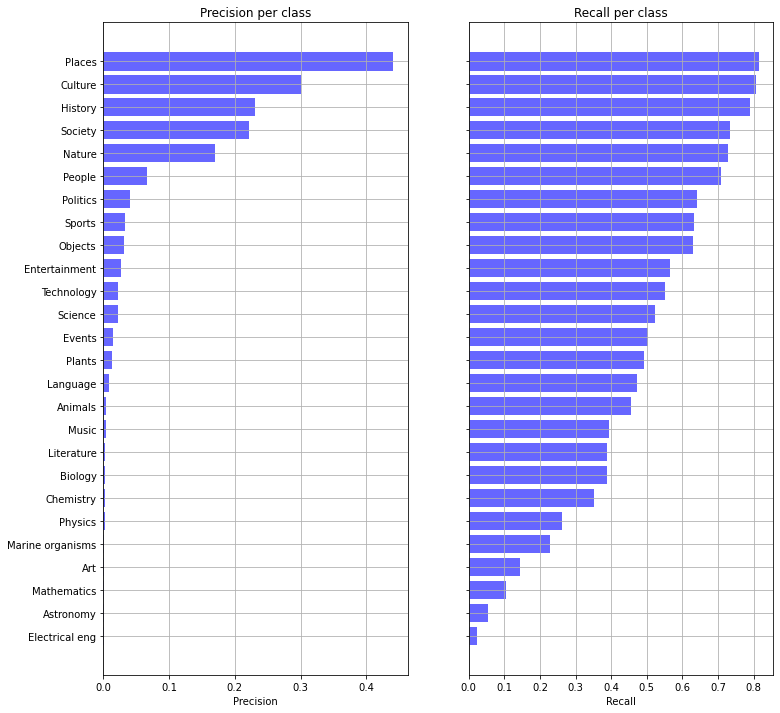

In [84]:
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, classification_report

# model = create_model()
# predictions_2 = model.predict(test, verbose=1)
# threshold = 0.5
y_pred = 1 * (predictions_2 > threshold)
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1
print(f'ROC AUC: {roc_auc_score(y_true, y_pred):.4f}')

N_CLASSES = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_CLASSES), [None, None, None, None]))
print(metrics_df)

fig, axs = plt.subplots(1, 2, figsize=(12,12))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:N_CLASSES])
sorted_precisions_per_class = metrics_df.precision[0:N_CLASSES][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:N_CLASSES])
sorted_recalls_per_class = metrics_df.recall[0:N_CLASSES][sorted_indices_recall]

print('\n\n ----------- PER-CLASS ACCURACY ----------- \n ')
# Per-class accuracy
from collections import Counter
total = Counter()
correct = Counter()
for i in range(len(test.classes)):
    true_y = test.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

name_id_map = test.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k
            
for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))
            
# -----------------------------------------------------------
    
axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(N_CLASSES))
axs[0].set_yticklabels(np.array(list(test.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)


axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(N_CLASSES))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)

Make predictions on the test set and then get classification metrics

ROC AUC: 0.5000


/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support index
Animals            0.000000  0.000000  0.000000     319.0     0
Art                0.000000  0.000000  0.000000      89.0     1
Astronomy          0.000000  0.000000  0.000000     166.0     2
Biology            0.000000  0.000000  0.000000     231.0     3
Chemistry          0.000000  0.000000  0.000000     249.0     4
Culture            0.290783  0.071171  0.114353   27174.0     5
Electrical eng     0.000000  0.000000  0.000000      46.0     6
Entertainment      0.032967  0.001239  0.002389    2421.0     7
Events             0.000000  0.000000  0.000000    1318.0     8
History            0.245698  0.029542  0.052742   20784.0     9
Language           0.000000  0.000000  0.000000     802.0    10
Literature         0.000000  0.000000  0.000000     226.0    11
Marine organisms   0.000000  0.000000  0.000000      96.0    12
Mathematics        0.000000  0.000000  0.000000      86.0    13
Music              0.000000  0.000000  0

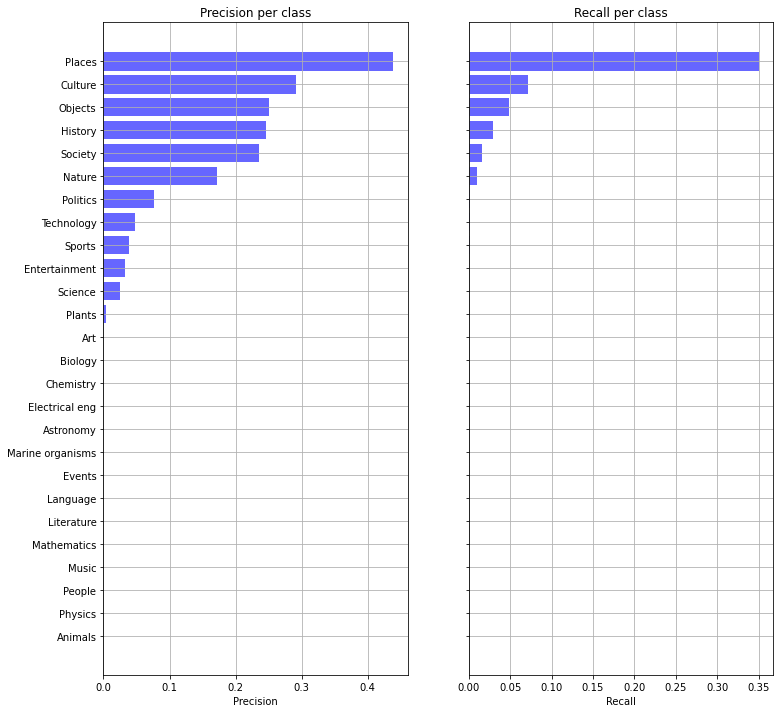

In [85]:
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, classification_report

# QUICK: load model weights and evaluate result on test set until now

# model = create_model()
# model.load_weights('checkpoints/naive_26_labels_no_weights_20220528/cp-0008.ckpt')
# predictions = model.predict(test, verbose=1)
threshold = 0.5
y_pred = 1 * (predictions > threshold)
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1
print(f'ROC AUC: {roc_auc_score(y_true, y_pred):.4f}')
# fig, axs = plt.subplots(1, 2, figsize=(12,12))

N_CLASSES = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_CLASSES), [None, None, None, None]))
print(metrics_df)

fig, axs = plt.subplots(1, 2, figsize=(12,12))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:N_CLASSES])
sorted_precisions_per_class = metrics_df.precision[0:N_CLASSES][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:N_CLASSES])
sorted_recalls_per_class = metrics_df.recall[0:N_CLASSES][sorted_indices_recall]

print('\n\n ----------- PER-CLASS ACCURACY ----------- \n ')
# Per-class accuracy
from collections import Counter
total = Counter()
correct = Counter()
for i in range(len(test.classes)):
    true_y = test.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1
            
name_id_map = test.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k
            
for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))

# -----------------------------------------------------------

axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(N_CLASSES))
axs[0].set_yticklabels(np.array(list(test.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)


axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(N_CLASSES))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)